# Se o Palmeiras não virar, olê, olê, olá... o que? oque?

Ete notebook complementa e oferece material de suporte ao meu artigo no Medium. Por simplicidade, deixarei toda a interpretação dos resultados para o artigo, me limitando, aqui, a rodar e documentar minimamente os códigos executados.

Apenas como referência, a ideia é confrontar os dados com as seguintes questões (sempre no contexto das duas principais competições nacionais do futebol masculino, o Campeonato Brasileiro e a Copa do Brasil):

**1** Com que frequência as equipes que saem atrás no placar conseguem virar o jogo? (pizza)

**2** O tempo de jogo no momento do primeiro gol é relevante para que a equipe adversária consiga virar o jogo? (histograma)

**3** Dada a frequência encontrada no item 1, existe alguma diferença:
  - entre equipes mandantes e visitantes? (sankey)
  - entre diferentes competições? (heatmap)
  - no caso da Copa do Brasil, que se dá inteiramente no formato "mata-mata":
    - entre partidas de ida e de volta? (barras)
    - entre partidas das fases preliminares e das fases de oitavas-de-final e posteriores? (barras)
**4** Ao saírem perdendo, qual é a capacidade de reação dos seguintes times:
  - Palmeiras
  - Flamengo
  - Atlético MG
  - Corinthians

## Setup

Aqui, carregamos as bibliotecas que serão utilizadas no notebook:

In [510]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [511]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
#import plotly.express as px
import pyarrow
import seaborn as sns
from pySankey import sankey

## Carregamento de dados

Utilizaremos os dados obtidos junto ao site da [CBF](https://www.cbf.com.br/) para as partidas das temporadas de 2012 a 2022 do Campeonato Brasileiro e da Copa do Brasil. A coleta e o tratamento desdes dados estão documentados [neste](1-coleta.ipynb) e [neste](2-tratamento.ipynb) notebooks.

In [38]:
# dados atômicos das partidas
df_partidas = pd.read_parquet('dados/partidas.parquet')
df_partidas.head()

,competicao,temporada,id_partida,estadio,cidade,uf,dia_semana,data,hora,mandante,visitante,mand_placar,visit_placar,disputa_penaltis,mand_penaltis,visit_penaltis
3900,Copa-do-Brasil,2012,1,Valmir Bezerra,Gama,DF,Quarta,2012-03-07,19:30:00,GAMA - DF,CEARA - CE,0,2,False,0,0
3901,Copa-do-Brasil,2012,2,Horácio Domingos,Horizonte,CE,Quarta,2012-03-07,20:30:00,HORIZONTE - CE,AMERICA - RN,2,0,False,0,0
3902,Copa-do-Brasil,2012,3,Passo das Emas,Lucas do Rio Verde,MT,Quarta,2012-03-07,20:30:00,LUVERDENSE - MT,PARANA - PR,2,2,False,0,0
3903,Copa-do-Brasil,2012,4,Nhozinho Santos,Sao Luis,MA,Quarta,2012-03-07,20:30:00,SAMPAIO CORREA - MA,ATLETICO - PR,2,1,False,0,0
3904,Copa-do-Brasil,2012,5,José Oimpio,Aguia Branca,ES,Quarta,2012-03-07,20:30:00,REAL NOROESTE CAPIXABA - ES,BETIM - MG,0,2,False,0,0


--------------------

In [39]:
# gols marcados em cada partida
df_gols = pd.read_parquet('dados/gols.parquet')
df_gols.head()

,competicao,temporada,id_partida,estadio,campo,equipe,pro_contra,jogador,minuto
0,Brasileirao,2012,104,Beira-Rio,mandante,INTERNACIONAL - RS,pro,Elton,20.0
4,Brasileirao,2012,104,Beira-Rio,visitante,ATLETICO - GO,pro,Renie,27.0
1,Brasileirao,2012,104,Beira-Rio,mandante,INTERNACIONAL - RS,pro,Dagoberto,46.0
2,Brasileirao,2012,104,Beira-Rio,mandante,INTERNACIONAL - RS,pro,Jakson Avelino,58.0
3,Brasileirao,2012,104,Beira-Rio,mandante,INTERNACIONAL - RS,pro,Fred,76.0


## Engenharia de recursos

Enriquecendo os dados com informações sobre a equipe que abriu o placar, a equipe vencedora e as viradas de placar:

In [40]:
# função que compara placares e identifica o vencedor de uma partida
def atribui_vencedor(mand_gols, visit_gols):
    vencedor = mand_gols - visit_gols # saldo de gols mandante
    # mapeia os saldos para valores entre [-1, 0, +1]:
    vencedor = vencedor.apply(lambda x: int(x/abs(x)) if x!=0 else x)
    # mapeia os valores numéricos para os rótulos em texto do resultado
    vencedor = vencedor.replace({-1:'visitante', 0:'empate', 1:'mandante'})
    return vencedor

In [41]:
# colunas que serão utilizadas como multiindex para concatenação dos dataframes
index_concat = ['competicao', 'temporada', 'id_partida']

In [42]:
# criando uma cópia do df de partidas
partidas = df_partidas.drop(columns=['estadio', 'uf'])
# vamos anotar o vencedor de cada partida (mandante ou visitante)
partidas['vencedor_regular'] = atribui_vencedor(partidas['mand_placar'], partidas['visit_placar'])
partidas['vencedor_penaltis'] = atribui_vencedor(partidas['mand_penaltis'], partidas['visit_penaltis'])
partidas.loc[~partidas['disputa_penaltis'], 'vencedor_penaltis'] = 'sem disputa de pênaltis'
partidas.set_index(index_concat, inplace=True)
partidas.sample(5)

cidade dia_semana        data  \
competicao     temporada id_partida                                          
Copa-do-Brasil 2020      118         Belo Horizonte     Quarta  2020-12-30   
Brasileirao    2021      147                 Recife      Sexta  2021-08-06   
               2017      150          Florianopolis     Quarta  2017-07-19   
               2016      10            Porto Alegre    Domingo  2016-05-15   
Copa-do-Brasil 2015      110          Florianopolis     Quarta  2015-05-13   

                                         hora            mandante  \
competicao     temporada id_partida                                 
Copa-do-Brasil 2020      118         21:30:00        AMERICA - MG   
Brasileirao    2021      147         19:00:00          SPORT - PE   
               2017      150         21:00:00           AVAI - SC   
               2016      10          18:30:00  INTERNACIONAL - RS   
Copa-do-Brasil 2015      110         22:00:00    FIGUEIRENSE - SC   

                                                    visitante  mand_placar  \
competicao     temporada id_partida                                          
Copa-do-Brasil 2020      118                   PALMEIRAS - SP            0   
Brasileirao    2021      147         RED BULL BRAGANTINO - SP            0   
               2017      150                 CORINTHIANS - SP            0   
               2016      10                  CHAPECOENSE - SC            0   
Copa-do-Brasil 2015      110                        AVAI - SC            2   

                                     visit_placar  disputa_penaltis  \
competicao     temporada id_partida                                   
Copa-do-Brasil 2020      118                    2             False   
Brasileirao    2021      147                    0             False   
               2017      150                    0             False   
               2016      10                     0             False   
Copa-do-Brasil 2015      110                    0             False   

                                     mand_penaltis  visit_penaltis  \
competicao     temporada id_partida                                  
Copa-do-Brasil 2020      118                     0               0   
Brasileirao    2021      147                     0               0   
               2017      150                     0               0   
               2016      10                      0               0   
Copa-do-Brasil 2015      110                     0               0   

                                    vencedor_regular        vencedor_penaltis  
competicao     temporada id_partida                                            
Copa-do-Brasil 2020      118               visitante  sem disputa de pênaltis  
Brasileirao    2021      147                  empate  sem disputa de pênaltis  
               2017      150                  empate  sem disputa de pênaltis  
               2016      10                   empate  sem disputa de pênaltis  
Copa-do-Brasil 2015      110                mandante  sem disputa de pênaltis

In [43]:
# para saber qual equipe abriu o placar, vamos obter o 1º gol de cada partida
tmp_gols = df_gols.copy()
tmp_gols.drop_duplicates(subset=index_concat, keep='first', inplace=True)
tmp_gols.set_index(index_concat, inplace=True)
tmp_gols.drop(columns=['estadio', 'equipe', 'pro_contra', 'jogador'], inplace=True)

#concatenando:
partidas = pd.concat([partidas, tmp_gols], axis=1)
partidas.rename(columns={'campo':'gol_inicial', 
                         'minuto':'gol_inicial_minuto'}, inplace=True)
partidas['gol_inicial'] = partidas['gol_inicial'].fillna('sem gols')
partidas.sample(5)

cidade dia_semana        data  \
competicao     temporada id_partida                                          
Brasileirao    2012      326         Belo Horizonte     Quarta  2012-10-31   
Copa-do-Brasil 2015      21               Saquarema     Quarta  2015-03-04   
Brasileirao    2021      222              Sao Paulo    Domingo  2021-10-03   
Copa-do-Brasil 2017      51                Sao Luis     Quarta  2017-03-01   
               2012      107              Fortaleza     Quarta  2012-05-02   

                                         hora             mandante  \
competicao     temporada id_partida                                  
Brasileirao    2012      326         21:50:00        ATLETICO - MG   
Copa-do-Brasil 2015      21          16:00:00        BOAVISTA - RJ   
Brasileirao    2021      222         18:15:00       PALMEIRAS - SP   
Copa-do-Brasil 2017      51          20:30:00  SAMPAIO CORREA - MA   
               2012      107         19:30:00       FORTALEZA - CE   

                                                    visitante  mand_placar  \
competicao     temporada id_partida                                          
Brasileirao    2012      326                    FLAMENGO - RJ            1   
Copa-do-Brasil 2015      21                          ABC - RN            0   
Brasileirao    2021      222                   JUVENTUDE - RS            1   
Copa-do-Brasil 2017      51          GUARANI DE JUAZEIRO - CE            2   
               2012      107                      GREMIO - RS            0   

                                     visit_placar  disputa_penaltis  \
competicao     temporada id_partida                                   
Brasileirao    2012      326                    1             False   
Copa-do-Brasil 2015      21                     1             False   
Brasileirao    2021      222                    1             False   
Copa-do-Brasil 2017      51                     0             False   
               2012      107                    2             False   

                                     mand_penaltis  visit_penaltis  \
competicao     temporada id_partida                                  
Brasileirao    2012      326                     0               0   
Copa-do-Brasil 2015      21                      0               0   
Brasileirao    2021      222                     0               0   
Copa-do-Brasil 2017      51                      0               0   
               2012      107                     0               0   

                                    vencedor_regular        vencedor_penaltis  \
competicao     temporada id_partida                                             
Brasileirao    2012      326                  empate  sem disputa de pênaltis   
Copa-do-Brasil 2015      21                visitante  sem disputa de pênaltis   
Brasileirao    2021      222                  empate  sem disputa de pênaltis   
Copa-do-Brasil 2017      51                 mandante  sem disputa de pênaltis   
               2012      107               visitante  sem disputa de pênaltis   

                                    gol_inicial  gol_inicial_minuto  
competicao     temporada id_partida                                  
Brasileirao    2012      326           sem gols                 NaN  
Copa-do-Brasil 2015      21           visitante                71.0  
Brasileirao    2021      222          visitante                 6.0  
Copa-do-Brasil 2017      51            mandante                48.0  
               2012      107           sem gols                 NaN

Toda partida sem gols deveria ter empate como resultado.

In [44]:
# checando registros inconsistentes, por temporada:
partidas.query('gol_inicial=="sem gols" and vencedor_regular!="empate"').reset_index()['temporada'].value_counts()

2012    363
2019      2
2016      1
Name: temporada, dtype: int64

O grande volume para a temporada de 2012 já era esperado pois, durante o tratamento dos dados, foi detectado que nem todas as partidas daquele ano tinham a indicação dos jogadores que marcaram gols. Para os propósitos desta análise, podemos excluir a temporada:

In [46]:
partidas = partidas.query('temporada > 2012')
gols = df_gols.query('temporada > 2012')

Vamos repetir a query para conferir os demais casos:

In [47]:
# checando novamente registros inconsistentes, por temporada:
partidas.query('gol_inicial=="sem gols" and vencedor_regular!="empate"')

cidade dia_semana        data  \
competicao     temporada id_partida                                         
Brasileirao    2016      292         Volta Redonda     Quinta  2016-10-13   
               2019      371          Porto Alegre    Domingo  2019-12-08   
Copa-do-Brasil 2019      70                Goiania      Terça  2019-04-16   

                                         hora            mandante  \
competicao     temporada id_partida                                 
Brasileirao    2016      292         21:00:00     FLUMINENSE - RJ   
               2019      371         16:00:00  INTERNACIONAL - RS   
Copa-do-Brasil 2019      70          20:00:00     BRAGANTINO - PA   

                                           visitante  mand_placar  \
competicao     temporada id_partida                                 
Brasileirao    2016      292           FLAMENGO - RJ            1   
               2019      371           ATLETICO - MG            2   
Copa-do-Brasil 2019      70          BRAGANTINO - PA            2   

                                     visit_placar  disputa_penaltis  \
competicao     temporada id_partida                                   
Brasileirao    2016      292                    2             False   
               2019      371                    1             False   
Copa-do-Brasil 2019      70                     0             False   

                                     mand_penaltis  visit_penaltis  \
competicao     temporada id_partida                                  
Brasileirao    2016      292                     0               0   
               2019      371                     0               0   
Copa-do-Brasil 2019      70                      0               0   

                                    vencedor_regular        vencedor_penaltis  \
competicao     temporada id_partida                                             
Brasileirao    2016      292               visitante  sem disputa de pênaltis   
               2019      371                mandante  sem disputa de pênaltis   
Copa-do-Brasil 2019      70                 mandante  sem disputa de pênaltis   

                                    gol_inicial  gol_inicial_minuto  
competicao     temporada id_partida                                  
Brasileirao    2016      292           sem gols                 NaN  
               2019      371           sem gols                 NaN  
Copa-do-Brasil 2019      70            sem gols                 NaN

Dado o pequeno volume, podemos buscar em outros sites os detalhes destas partidas para corrigir, manualmente, os registros:

In [48]:
# partida 1: FLAMENGO - RJ saiu na frente aos 11 minutos do 1ºT
# fonte: http://ge.globo.com/rj/futebol/brasileirao-serie-a/jogo/13-10-2016/fluminense-flamengo/
partidas.loc[('Brasileirao', 2016, 292), 'gol_inicial'] = 'visitante'
partidas.loc[('Brasileirao', 2016, 292), 'gol_inicial_minuto'] = 11.0

In [49]:
# partida 2: ATLETICO - MG saiu na frente aos 5 minutos do 1ºT
# fonte: https://ge.globo.com/rs/futebol/brasileirao-serie-a/jogo/08-12-2019/internacional-atletico-mg.ghtml
partidas.loc[('Brasileirao', 2019, 371), 'gol_inicial'] = 'visitante'
partidas.loc[('Brasileirao', 2019, 371), 'gol_inicial_minuto'] = 5.0

In [50]:
# partida 3: aqui, percebe-se que o site da CBF não apresenta corretamente os times
# o mandante foi o VILA NOVA -GO, que abriu o placar aos 6 minutos do 1ºT contra o BRAGANTINO -PA
# fonte: https://www.cbf.com.br/futebol-brasileiro/competicoes/copa-brasil-masculino/2019/70#resumo
partidas.loc[('Copa-do-Brasil', 2019, 70), 'mandante'] = 'VILA NOVA - GO'
partidas.loc[('Copa-do-Brasil', 2019, 70), 'gol_inicial'] = 'mandante'
partidas.loc[('Copa-do-Brasil', 2019, 70), 'gol_inicial_minuto'] = 6.0

Vamos conferir se os registros agora estão corretos:

In [52]:
tmp_idx = [('Brasileirao', 2016, 292), ('Brasileirao', 2019, 371), ('Copa-do-Brasil', 2019, 70)]
partidas.loc[tmp_idx]

cidade dia_semana        data  \
competicao     temporada id_partida                                         
Brasileirao    2016      292         Volta Redonda     Quinta  2016-10-13   
               2019      371          Porto Alegre    Domingo  2019-12-08   
Copa-do-Brasil 2019      70                Goiania      Terça  2019-04-16   

                                         hora            mandante  \
competicao     temporada id_partida                                 
Brasileirao    2016      292         21:00:00     FLUMINENSE - RJ   
               2019      371         16:00:00  INTERNACIONAL - RS   
Copa-do-Brasil 2019      70          20:00:00      VILA NOVA - GO   

                                           visitante  mand_placar  \
competicao     temporada id_partida                                 
Brasileirao    2016      292           FLAMENGO - RJ            1   
               2019      371           ATLETICO - MG            2   
Copa-do-Brasil 2019      70          BRAGANTINO - PA            2   

                                     visit_placar  disputa_penaltis  \
competicao     temporada id_partida                                   
Brasileirao    2016      292                    2             False   
               2019      371                    1             False   
Copa-do-Brasil 2019      70                     0             False   

                                     mand_penaltis  visit_penaltis  \
competicao     temporada id_partida                                  
Brasileirao    2016      292                     0               0   
               2019      371                     0               0   
Copa-do-Brasil 2019      70                      0               0   

                                    vencedor_regular        vencedor_penaltis  \
competicao     temporada id_partida                                             
Brasileirao    2016      292               visitante  sem disputa de pênaltis   
               2019      371                mandante  sem disputa de pênaltis   
Copa-do-Brasil 2019      70                 mandante  sem disputa de pênaltis   

                                    gol_inicial  gol_inicial_minuto  
competicao     temporada id_partida                                  
Brasileirao    2016      292          visitante                11.0  
               2019      371          visitante                 5.0  
Copa-do-Brasil 2019      70            mandante                 6.0

Uma nova checage de inconsistências não deveria retornar nenhum registro. Vejamos:

In [53]:
# checando mais uma ves registros inconsistentes, por temporada:
partidas.query('gol_inicial=="sem gols" and vencedor_regular!="empate"')

,,,cidade,dia_semana,data,hora,mandante,visitante,mand_placar,visit_placar,disputa_penaltis,mand_penaltis,visit_penaltis,vencedor_regular,vencedor_penaltis,gol_inicial,gol_inicial_minuto
competicao,temporada,id_partida,,,,,,,,,,,,,,,


### 1. Com que frequência as equipes conseguem reverter a vantagem nas competições nacionais?

Fazendo um cruzamento entre a equipe que abriu o placar e resultado final da partida (no tempo normal de jogo), podemos identificar os casos em que a primeira equipe a marcar gol foi derrotada:

In [177]:
# por competição - números absolutos

seq_cols = ['mandante', 'empate', 'visitante']

viradas_geral = pd.crosstab(partidas['gol_inicial'], partidas['vencedor_regular'])[seq_cols]
viradas_geral.columns = cols_geral = pd.MultiIndex.from_tuples([c for c in zip(['Geral']*3, seq_cols)])

viradas_camp = pd.crosstab(partidas.query('competicao=="Brasileirao"')['gol_inicial'], 
                           partidas.query('competicao=="Brasileirao"')['vencedor_regular'])[seq_cols]
viradas_camp.columns = pd.MultiIndex.from_tuples([c for c in zip(['Brasileirao']*3, seq_cols)])

viradas_copa = pd.crosstab(partidas.query('competicao=="Copa-do-Brasil"')['gol_inicial'], 
                           partidas.query('competicao=="Copa-do-Brasil"')['vencedor_regular'])[seq_cols]
viradas_copa.columns = pd.MultiIndex.from_tuples([c for c in zip(['Copa-do-Brasil']*3, seq_cols)])

viradas_cross = pd.concat([viradas_geral, viradas_camp, viradas_copa], axis=1)
viradas_cross

Geral                  Brasileirao                   \
            mandante empate visitante    mandante empate visitante   
gol_inicial                                                          
mandante        2039    435       167        1522    320       120   
sem gols           0    441         0           0    320         0   
visitante        262    431      1073         199    311       727   

            Copa-do-Brasil                   
                  mandante empate visitante  
gol_inicial                                  
mandante               517    115        47  
sem gols                 0    121         0  
visitante               63    120       346

In [245]:
# por competição - percentuais em relação ao total de partidas da competição
viradas_percent = None
for comp in viradas_cross.columns.levels[0]:
    df_tmp = viradas_cross.loc[:, comp]
    total = df_tmp.sum().sum()
    df_tmp = df_tmp.apply(lambda x: x/total*100)
    df_tmp.columns = pd.MultiIndex.from_tuples([(comp, col) for col in df_tmp.columns])
    viradas_percent = pd.concat([viradas_percent, df_tmp], axis=1)
viradas_percent

Brasileirao                      Copa-do-Brasil            \
               mandante    empate  visitante       mandante    empate   
gol_inicial                                                             
mandante      43.250924  9.093492   3.410060      38.901430  8.653123   
sem gols       0.000000  9.093492   0.000000       0.000000  9.104590   
visitante      5.655016  8.837738  20.659278       4.740406  9.029345   

                            Geral                       
             visitante   mandante    empate  visitante  
gol_inicial                                             
mandante      3.536494  42.058581  8.972772   3.444719  
sem gols      0.000000   0.000000  9.096535   0.000000  
visitante    26.034612   5.404290  8.890264  22.132838

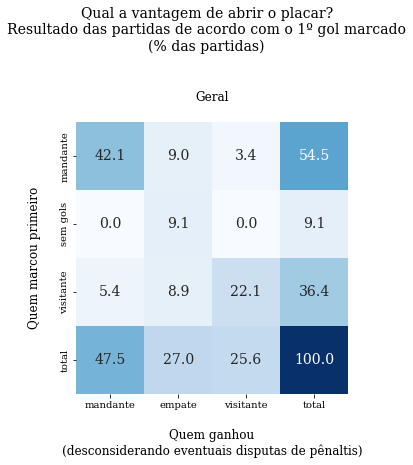

In [513]:
plt.figure(figsize=(6, 5))
data = viradas_percent.loc[:, 'Geral'].copy()
data.loc[:, 'total'] = data.sum(axis=1)
data.loc['total', :] = data.sum(axis=0)
sns.heatmap(data, annot=True, fmt='.1f', cmap='Blues', square=True, cbar=False)
plt.suptitle('Qual a vantagem de abrir o placar?\nResultado das partidas de acordo com o 1º gol marcado\n(% das partidas)', size=14, x=0.50, y=1.2)
plt.title('Geral\n', size=12)
plt.xlabel('\nQuem ganhou\n(desconsiderando eventuais disputas de pênaltis)', size=12, y=2.5)
plt.xticks(size=10, rotation=0)
plt.ylabel('Quem marcou primeiro\n', size=12)
plt.yticks(size=10, rotation=90)
plt.show()

In [520]:
# ANOTAR OS PERCENTUAIS DINAMICAMENTE:
mand_mand = round(data.loc['mandante', 'mandante'], 1)
mand_emp = round(data.loc['mandante', 'empate'], 1)
mand_visit = round(data.loc['mandante', 'visitante'], 1)
visit_mand = round(data.loc['visitante', 'mandante'], 1)
visit_emp = round(data.loc['visitante', 'empate'], 1)
visit_visit = round(data.loc['visitante', 'visitante'], 1)
sem_gols = round(data.loc['sem gols', 'empate'], 1)

In [573]:
# com gráfico sankey
colors = {
    'mandante': '#5799c6',
    'visitante': '#fb6d4d',
    'empate': 'silver',
    'sem gols': 'silver'
}

In [571]:
colors = {
    'mandante': {'mandante': '#5799c6'},
    'mandante': {'empate': '#5799c6'},
    'mandante': {'visitante': '#5799c6'},
    'visitante': {'mandante': '#fb6d4d'},
    'visitante': {'empate': '#fb6d4d'},
    'visitante': {'visitante': '#fb6d4d'},
    'sem gols': {'empate': 'silver'},
    'empate': {'empate': 'silver'}
}

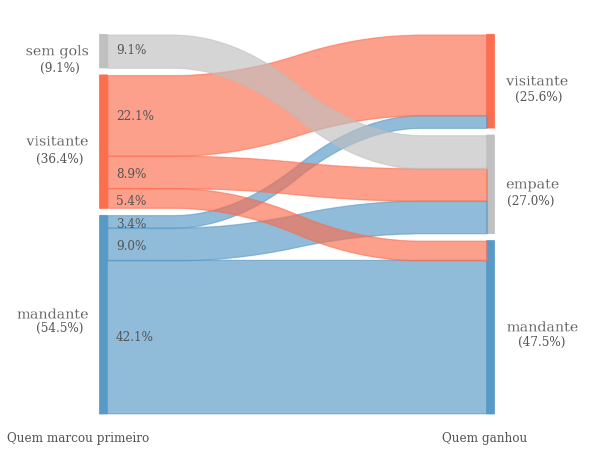

In [574]:
plt.rc('font', family='sans-serif')
sankey.sankey(partidas['gol_inicial'], partidas['vencedor_regular'], 
              fontsize=11, colorDict=colors, figure_name='img/sankey', closePlot=True)
#plt.savefig('img/sankey.png')
img = plt.imread('img/sankey.png')
plt.figure(figsize=(12,8))
plt.imshow(img, extent=[0, 1600, 0, 1200])

plt.rc('text', color='#555')
plt.text(0, 0, 'Quem marcou primeiro')
plt.text(1200, 0, 'Quem ganhou')

plt.rc('font', size=12)
plt.text(300, 1070, f'{sem_gols}%')
plt.text(300, 890, f'{visit_visit}%')
plt.text(300, 730, f'{visit_emp}%')
plt.text(300, 655, f'{visit_mand}%')
plt.text(300, 592, f'{mand_visit}%')
plt.text(300, 530, f'{mand_emp}%')
plt.text(300, 280, f'{mand_mand}%')

plt.text(90, 1020, '({:.1f}%)'.format(data.loc['sem gols', 'total']))
plt.text(80, 770, '({:.1f}%)'.format(data.loc['visitante', 'total']))
plt.text(80, 303, '({:.1f}%)'.format(data.loc['mandante', 'total']))

plt.text(1400, 940, '({:.1f}%)'.format(data.loc['total', 'visitante']))
plt.text(1380, 655, '({:.1f}%)'.format(data.loc['total', 'empate']))
plt.text(1410, 265, '({:.1f}%)'.format(data.loc['total', 'mandante']))

plt.axis('off')
plt.show()

- Observa-se que os times mandantes abrem o placar com muito mais frequência do que os visitantes.
- Os mandantes saem do campo com a vitória numa frequência maior do que os visitantes.
- No geral, as viradas de placar ocorrem em apenas 8,8% dos jogos.

### 2. Levar o gol mais cedo torna mais fácil ou mais difícil para a outra equipe reverter o placar?

In [123]:
mand_evolucao_placar_map = {
    'sem gols': {'empate': 'sem_gols'},
    'mandante': {'mandante':'manteve vantagem', 'empate':'sofreu empate', 'visitante':'sofreu virada'},
    'visitante': {'mandante':'conquistou virada', 'empate':'conquistou empate', 'visitante':'manteve desvantagem'},
}
mand_evolucao_placar = []
for _, row in partidas.iterrows():
    gol_inicial = row['gol_inicial']
    vencedor = row['vencedor_regular']
    evolucao = mand_evolucao_placar_map[gol_inicial][vencedor]
    mand_evolucao_placar.append(evolucao)
partidas['mand_evolucao_placar'] = mand_evolucao_placar
partidas.sample(5)

cidade dia_semana        data  \
competicao     temporada id_partida                                          
Brasileirao    2017      242                 Santos     Sábado  2017-09-23   
Copa-do-Brasil 2013      99               Joinville     Quarta  2013-05-08   
               2017      92          Rio de Janeiro     Quarta  2017-04-26   
Brasileirao    2022      96           Caxias do Sul     Quarta  2022-06-08   
               2019      341           Porto Alegre     Quarta  2019-11-27   

                                         hora            mandante  \
competicao     temporada id_partida                                 
Brasileirao    2017      242         21:00:00         SANTOS - SP   
Copa-do-Brasil 2013      99          22:00:00      JOINVILLE - SC   
               2017      92          21:45:00       BOTAFOGO - RJ   
Brasileirao    2022      96          19:00:00      JUVENTUDE - RS   
               2019      341         19:30:00  INTERNACIONAL - RS   

                                         visitante  mand_placar  visit_placar  \
competicao     temporada id_partida                                             
Brasileirao    2017      242         ATLETICO - PR            1             0   
Copa-do-Brasil 2013      99            SANTOS - SP            0             1   
               2017      92             SPORT - PE            2             1   
Brasileirao    2022      96          ATLETICO - PR            1             3   
               2019      341            GOIAS - GO            1             2   

                                     disputa_penaltis  mand_penaltis  \
competicao     temporada id_partida                                    
Brasileirao    2017      242                    False              0   
Copa-do-Brasil 2013      99                     False              0   
               2017      92                     False              0   
Brasileirao    2022      96                     False              0   
               2019      341                    False              0   

                                     visit_penaltis vencedor_regular  \
competicao     temporada id_partida                                    
Brasileirao    2017      242                      0         mandante   
Copa-do-Brasil 2013      99                       0        visitante   
               2017      92                       0         mandante   
Brasileirao    2022      96                       0        visitante   
               2019      341                      0        visitante   

                                           vencedor_penaltis gol_inicial  \
competicao     temporada id_partida                                        
Brasileirao    2017      242         sem disputa de pênaltis    mandante   
Copa-do-Brasil 2013      99          sem disputa de pênaltis   visitante   
               2017      92          sem disputa de pênaltis   visitante   
Brasileirao    2022      96          sem disputa de pênaltis    mandante   
               2019      341         sem disputa de pênaltis   visitante   

                                     gol_inicial_minuto mand_evolucao_placar  
competicao     temporada id_partida                                           
Brasileirao    2017      242                       35.0     manteve vantagem  
Copa-do-Brasil 2013      99                        83.0  manteve desvantagem  
               2017      92                         9.0    conquistou virada  
Brasileirao    2022      96                        38.0        sofreu virada  
               2019      341                       14.0  manteve desvantagem

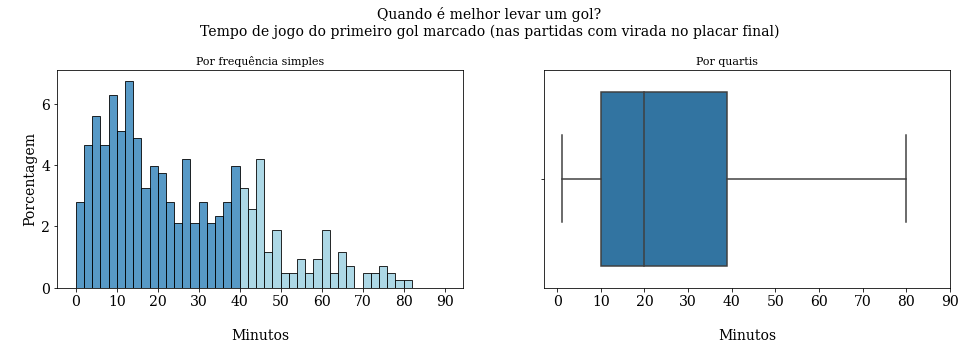

In [508]:
idx_viradas = partidas['mand_evolucao_placar'].str.contains('virada')
viradas = partidas.loc[idx_viradas]
fig, axs = plt.subplots(1, 2, figsize=(16,4))
plt.rc('font', family='serif')
plt.suptitle('Quando é melhor levar um gol?\nTempo de jogo do primeiro gol marcado (nas partidas com virada no placar final)\n', size=14, y=1.1)
plt.title('Tempo de jogo do primeiro gol marcado nas partidas com virada no placar final\n', x=-.15, size=14,)
sns.histplot(viradas, x='gol_inicial_minuto', bins=45, binrange=(0,90), stat='percent', ax=axs[0])
#sns.histplot(viradas, x='gol_inicial_minuto', bins=45, binrange=(0,90), cumulative=True, stat='percent', ax=axs[1])
#sns.lineplot(x=[0,90], y=[80,80], color='orange', ax=axs[1])
sns.boxplot(x=viradas['gol_inicial_minuto'], ax=axs[1]).set_xticks(range(0,91,10))
axs[0].set_title('Por frequência simples')
axs[0].set_xticks(range(0, 91, 10))
axs[0].set_xlabel('\nMinutos')
axs[0].set_ylabel('\nPorcentagem')
axs[1].set_title('Por quartis', x=.45)
#axs[1].set_xticks(range(0, 91, 15))
axs[1].set_xlabel('\nMinutos')
for i in range(20, 45):
    axs[0].patches[i].set_facecolor('lightblue')
plt.show()

- 75% das viradas ocorreram quando o primeiro gol foi marcado até os 40 minutos do 1º tempo
- Nenhuma virada ocorreu quando o primeiro gol foi marcado após os 80 minutos de jogo (35 minutos do 2º tempo).

### 3. Existe alguma diferença entre equipes mandantes e visitantes?

In [ ]:
gol_inicial_vencedor = [f'{row.gol_inicial}-{row.vencedor}' for _, row in partidas.iterrows()]
gol_inicial_vencedor = pd.Series(gol_inicial_vencedor)
gol_inicial_vencedor = round(gol_inicial_vencedor.value_counts(normalize=True) * 100, 2)
gol_inicial_vencedor[['sem gols-empate', 
                      'visitante-visitante', 'visitante-empate', 'visitante-mandante',
                      'mandante-visitante', 'mandante-empate', 'mandante-mandante']]

In [ ]:
sankey.sankey(partidas['gol_inicial'], partidas['vencedor'])

In [ ]:
abertura_mandante = gol_inicial_vencedor[gol_inicial_vencedor.index.str.startswith('mandante')].sum()
abertura_visitante = gol_inicial_vencedor[gol_inicial_vencedor.index.str.startswith('visitante')].sum()

print('Mandantes abrem o placar em {partidas:.2f}% das partidas'.format(partidas=abertura_mandante))
print('\tDestas partidas, o time mandante:')
print('\t\t- mantém a vantagem em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['mandante-mandante']/abertura_mandante*100))
print('\t\t- cede o empate em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['mandante-empate']/abertura_mandante*100))
print('\t\t- leva a virada em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['mandante-visitante']/abertura_mandante*100))      

print('Visitantes abrem o placar em {partidas:.2f}% das partidas'.format(partidas=abertura_visitante))
print('\tDestas partidas, o time visitante:')
print('\t\t- mantém a vantagem em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['visitante-visitante']/abertura_visitante*100))
print('\t\t- cede o empate em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['visitante-empate']/abertura_visitante*100))
print('\t\t- leva a virada em {partidas:.2f}% das vezes'.format(partidas=gol_inicial_vencedor['visitante-mandante']/abertura_visitante*100))

print('Viradas acontecem somente em {partidas:.2f}% das partidas'.format(partidas=gol_inicial_vencedor['mandante-visitante']+gol_inicial_vencedor['visitante-mandante']))

- A chance do mandante abrir o placar é 1.5 vezes a chance do visitante abrir o placar
- A chance do mandante reverter um placar inicial desfavorável é 2.3 vezes a chance do visitante conseguir o mesmo

### 4. Existe alguma diferença entre diferentes competições?

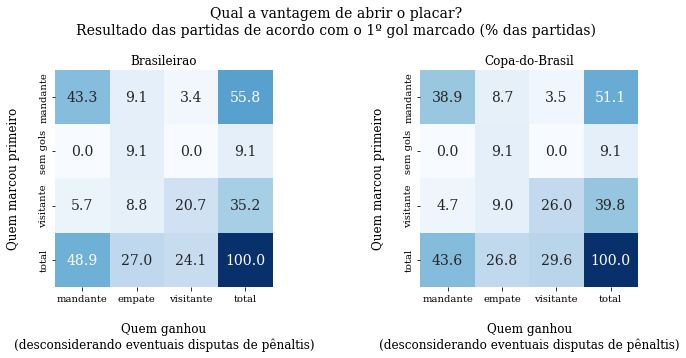

In [509]:
competicoes = ['Brasileirao', 'Copa-do-Brasil']
colors = ['Blues', 'Blues']

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#plt.rc('font', size=14)
plt.suptitle('Qual a vantagem de abrir o placar?\nResultado das partidas de acordo com o 1º gol marcado (% das partidas)', size=14, y=1.1)
for i in range(2):
    data = viradas_percent.loc[:, competicoes[i]].copy()
    data.loc[:, 'total'] = data.sum(axis=1)
    data.loc['total', :] = data.sum(axis=0)
    sns.heatmap(data, annot=True, fmt='.1f', cmap=colors[i], square=True, cbar=False, ax=axs[i])
    axs[i].set_title(competicoes[i], size=12)
    axs[i].set_xlabel('\nQuem ganhou\n(desconsiderando eventuais disputas de pênaltis)', size=12)
    axs[i].set_xticklabels(data.columns, size=10, rotation=0)
    axs[i].set_ylabel('Quem marcou primeiro\n', size=12)
    axs[i].set_yticklabels(data.index, size=10, rotation=90)
plt.show()

- É possível perceber um maior equilíbrio nas partidas da Copa do Brasil em relação ao Campeonato Brasileiro. Um dos motivos pode ser o fato de que o nível técnico das equipes é muito mais heterogênio na Copa, o que pode pode fazer com que os times maiores tenham mais condições de abrir o placar e vencer a partida.
- No geral, as viradas de placar ocorrem em apenas 8,8% dos jogos, tendo uma frequência maior no Campeonato Brasileiro (9,1%) do que na Copa do Brasil (8,2%).

### Existe alguma diferença entre partidas de ida e de volta da Copa do Brasil?

In [71]:
l = [x for x in range(10)]
L = iter(l)

In [81]:
try:
    i = next(L)
    n = i+1
    print(n)
    l.remove(n)
    print(l)
    L = iter(l[l.index(i)+1:])
except StopIteration as e:
    pass

In [82]:
l

[0, 2, 4, 6, 8]

In [211]:
df_target = partidas.query('competicao=="Copa-do-Brasil"').copy()
df_outro = df_target.copy()

jogos_ida = []
jogos_volta = []
jogos_idx = []

for idx in df_target.index:
    ida = df_target.loc[idx].to_dict()
    jogos_ida.append(ida)
    jogos_idx.append(idx)
    df_target.drop(index=idx, inplace=True)
    
    temporada = idx[1]
    mandante = ida['mandante']
    visitante = ida['visitante']
    
    try:
        volta = df_target.loc['Copa-do-Brasil'].loc[temporada].query('mandante==@visitante and visitante==@mandante')    
        if isinstance(volta, pd.Series):
            id_partida_volta = volta.name
            volta = volta.to_dict()
        elif isinstance(volta, pd.DataFrame) and volta.shape[0]>0:
            volta = volta.iloc[0]
            id_partida_volta = volta.name
            volta = volta.to_dict()
        else:
            volta = {col:np.nan for col in partidas.columns}
            id_partida_volta = np.nan
        volta['id_partida_volta'] = id_partida_volta
        jogos_volta.append(volta)
         #print(ida.name, volta.name)
    except KeyError:
        print('nenhuma partida encontrada')

nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada
nenhuma partida encontrada


In [214]:
jogos_ida_df = pd.DataFrame(jogos_ida)#, index=pd.MultiIndex.from_arrays(jogos_idx))
jogos_ida_df

,estadio,cidade,uf,dia_semana,data,hora,mandante,visitante,mand_placar,visit_placar,disputa_penaltis,mand_penaltis,visit_penaltis,gol_inicial,gol_inicial_minuto,vencedor
0,Arena da Floresta,Rio Branco,AC,Quarta,2013-02-27,20:00:00,ATLETICO - AC,DESPORTIVA FERROVIARIA - ES,1,1,False,0,0,visitante,41.0,empate
1,Alencar Araripe,None,None,Quarta,2013-03-13,20:30:00,DESPORTIVA FERROVIARIA - ES,ATLETICO - AC,5,4,False,0,0,mandante,32.0,mandante
2,Olímpico do Pará,Belem,PA,Quarta,2013-04-03,22:00:00,REMO - PA,FLAMENGO - RJ,0,1,False,0,0,visitante,54.0,visitante
3,Maria Abadia,Ceilândia,DF,Quarta,2013-04-03,16:00:00,CEILANDIA - DF,CEARA - CE,0,0,False,0,0,sem gols,NaN,empate
4,Arena da Floresta,Rio Branco,AC,Quarta,2013-04-03,22:00:00,RIO BRANCO - AC,INTERNACIONAL - RS,0,2,False,0,0,visitante,63.0,visitante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,Arena Barueri,Barueri,SP,Quinta,2022-05-12,19:30:00,SAO PAULO - SP,JUVENTUDE - RS,2,0,False,0,0,mandante,27.0,mandante
1324,Nilton Santos,Rio de Janeiro,RJ,Quinta,2022-05-12,21:30:00,BOTAFOGO - RJ,CEILANDIA - DF,3,0,False,0,0,mandante,40.0,mandante
1325,Vila Belmiro,Santos,SP,Quinta,2022-05-12,21:30:00,SANTOS - SP,CORITIBA - PR,3,0,False,0,0,mandante,48.0,mandante
1326,Nabi Abi Chedid,Braganca Paulista,SP,Terça,2022-05-31,21:30:00,RED BULL BRAGANTINO - SP,GOIAS - GO,0,1,True,8,9,visitante,43.0,visitante


In [215]:
jogos_volta_df = pd.DataFrame(jogos_volta)#, index=pd.MultiIndex.from_arrays(jogos_idx))
jogos_volta_df

,estadio,cidade,uf,dia_semana,data,hora,mandante,visitante,mand_placar,visit_placar,disputa_penaltis,mand_penaltis,visit_penaltis,gol_inicial,gol_inicial_minuto,vencedor,id_partida_volta
0,Alencar Araripe,None,None,Quarta,2013-03-13,20:30:00,DESPORTIVA FERROVIARIA - ES,ATLETICO - AC,5.0,4.0,False,0.0,0.0,mandante,32.0,mandante,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Raulino de Oliveira,Volta Redonda,RJ,Quarta,2013-04-17,22:00:00,FLAMENGO - RJ,REMO - PA,3.0,0.0,False,0.0,0.0,mandante,35.0,mandante,48.0
3,Castelão,Fortaleza,CE,Quarta,2013-04-10,22:00:00,CEARA - CE,CEILANDIA - DF,4.0,3.0,False,0.0,0.0,visitante,9.0,mandante,43.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
